In [13]:
import xarray as xr
from cmip6_preprocessing.preprocessing import combined_preprocessing
#import PyCO2SYS as pyco2 # i have to install this package through terminal for it to work
import intake
import matplotlib.pyplot as plt
import numpy as np
import warnings
import gsw
warnings.filterwarnings("ignore")
from cmip6_preprocessing.postprocessing import combine_datasets

In [4]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

The original subset of models is `['IPSL-CM6A-LR', 'CNRM-ESM2-1', 'CESM2', 'CanESM5', 'CanESM5-CanOE', 'MPI-ESM-1-2-HAM', 'UKESM1-0-LL', 'MPI-ESM1-2-LR', 'MPI-ESM1-2-HR', 'CESM2-WACCM', 'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'MIROC-ES2L', 'ACCESS-ESM1-5','CESM2-WACCM-FV2', 'CESM2-FV2']`.

But I'm choosing a sub-subset of models that had multiple members and caused some problems, since it'll be easier to debug with fewer models.

In [11]:
cat = col.search(source_id = ['CanESM5'], variable_id= 'so', experiment_id= 'historical', table_id = 'Omon', grid_label = 'gn')
dd = cat.to_dataset_dict(
    zarr_kwargs={'consolidated': True, 'use_cftime':True},
    storage_options={'token': 'anon'},
    preprocess=combined_preprocessing,
    aggregate=False)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [12]:
dd

{'CMIP.CCCma.CanESM5.historical.r28i1p2f1.Omon.so.gn.gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical/r28i1p2f1/Omon/so/gn/v20190429/.nan.20190429': <xarray.Dataset>
 Dimensions:             (bnds: 2, lev: 45, time: 1980, vertex: 4, x: 360, y: 291)
 Coordinates:
   * x                   (x) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
   * y                   (y) float64 -78.39 -78.19 -77.98 ... 71.57 71.62 71.65
     lat                 (y, x) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
   * lev                 (lev) float64 3.047 9.454 16.36 ... 5.375e+03 5.625e+03
     lev_bounds          (lev, bnds) float64 dask.array<chunksize=(45, 2), meta=np.ndarray>
     lon                 (y, x) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
   * time                (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:0...
     time_bounds         (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
     vertices_latitude   (y, x, vertex) float64 d

In [18]:
cat_so = col.search(source_id = ['CanESM5'], variable_id= 'so', experiment_id= 'historical', table_id = 'Omon', grid_label = 'gn')

dd_so_CanESM5_1 = cat_so.to_dataset_dict(
    zarr_kwargs={'consolidated': True, 'use_cftime':True},
    storage_options={'token': 'anon'},
    preprocess=combined_preprocessing,
    aggregate=False)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [19]:
def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

dd_so_CanESM5 = combine_datasets(
    dd_so_CanESM5_1,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id'])

In [20]:
dd_so_CanESM5

{'CanESM5.gn.historical.Omon': <xarray.Dataset>
 Dimensions:             (bnds: 2, lev: 45, time: 1980, vertex: 4, x: 360, y: 291)
 Coordinates:
   * x                   (x) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
   * y                   (y) float64 -78.39 -78.19 -77.98 ... 71.57 71.62 71.65
     lat                 (y, x) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
   * lev                 (lev) float64 3.047 9.454 16.36 ... 5.375e+03 5.625e+03
     lev_bounds          (lev, bnds) float64 dask.array<chunksize=(45, 2), meta=np.ndarray>
     lon                 (y, x) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
   * time                (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:0...
     time_bounds         (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
     vertices_latitude   (y, x, vertex) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
     vertices_longitude  (y, x, vertex) float64 dask.array<chunk

### Salinity

In [22]:
cat_so_all = col.search(source_id = ['IPSL-CM6A-LR', 'CNRM-ESM2-1', 'CESM2', 'CanESM5', 'CanESM5-CanOE', 
                             'MPI-ESM-1-2-HAM', 'UKESM1-0-LL', 'MPI-ESM1-2-LR', 'MPI-ESM1-2-HR', 
                             'CESM2-WACCM', 'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'MIROC-ES2L', 'ACCESS-ESM1-5',
                             'CESM2-WACCM-FV2', 'CESM2-FV2'], variable_id= 'so', experiment_id= 'historical', table_id = 'Omon', grid_label = 'gn')
dd_so_all_1 = cat_so_all.to_dataset_dict(
    zarr_kwargs={'consolidated': True, 'use_cftime':True},
    storage_options={'token': 'anon'},
    preprocess=combined_preprocessing,
    aggregate=False)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


MIROC-ES2L: No units found
MIROC-ES2L: No units found
MIROC-ES2L: No units found
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
MIROC-ES2L: No units found
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
MIROC-ES2L: No units found
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
MIROC-ES2L: No units found
CESM2-WACCM: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
MIROC-ES2L: No units found
CESM2-WACCM-FV2: Unexp

In [23]:
dd_so_all = combine_datasets(
    dd_so_all_1,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id'])

In [24]:
dd_so_all

{'GISS-E2-1-G.gn.historical.Omon': <xarray.Dataset>
 Dimensions:      (bnds: 2, lev: 40, time: 1980, x: 288, y: 180)
 Coordinates:
   * y            (y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
     lat_bounds   (y, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
   * lev          (lev) float64 5.0 16.0 29.0 ... 4.453e+03 4.675e+03 4.897e+03
     lev_bounds   (lev, bnds) float64 dask.array<chunksize=(40, 2), meta=np.ndarray>
   * x            (x) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
     lon_bounds   (x, bnds) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
   * time         (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
     time_bounds  (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
   * bnds         (bnds) int64 0 1
     lon          (x, y) float64 0.625 0.625 0.625 0.625 ... 359.4 359.4 359.4
     lat          (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
 Data variables:
 

In [26]:
for name, ds in dd_so_all.items():
    print(ds.attrs['source_id']+' ' +ds.attrs['variant_label']+' ' +ds.attrs['table_id'])

GISS-E2-1-G r10i1p1f2 Omon
MPI-ESM1-2-LR r7i1p1f1 Omon
UKESM1-0-LL r8i1p1f2 Omon
CanESM5 r1i1p1f1 Omon
IPSL-CM6A-LR r31i1p1f1 Omon
MIROC-ES2L r2i1p1f2 Omon
ACCESS-ESM1-5 r2i1p1f1 Omon
CESM2 r8i1p1f1 Omon
CanESM5-CanOE r1i1p2f1 Omon
CNRM-ESM2-1 r8i1p1f2 Omon
CESM2-WACCM r2i1p1f1 Omon
MPI-ESM1-2-HR r9i1p1f1 Omon
CESM2-WACCM-FV2 r1i1p1f1 Omon
CESM2-FV2 r1i1p1f1 Omon
GISS-E2-1-G-CC r1i1p1f1 Omon
MPI-ESM-1-2-HAM r1i1p1f1 Omon


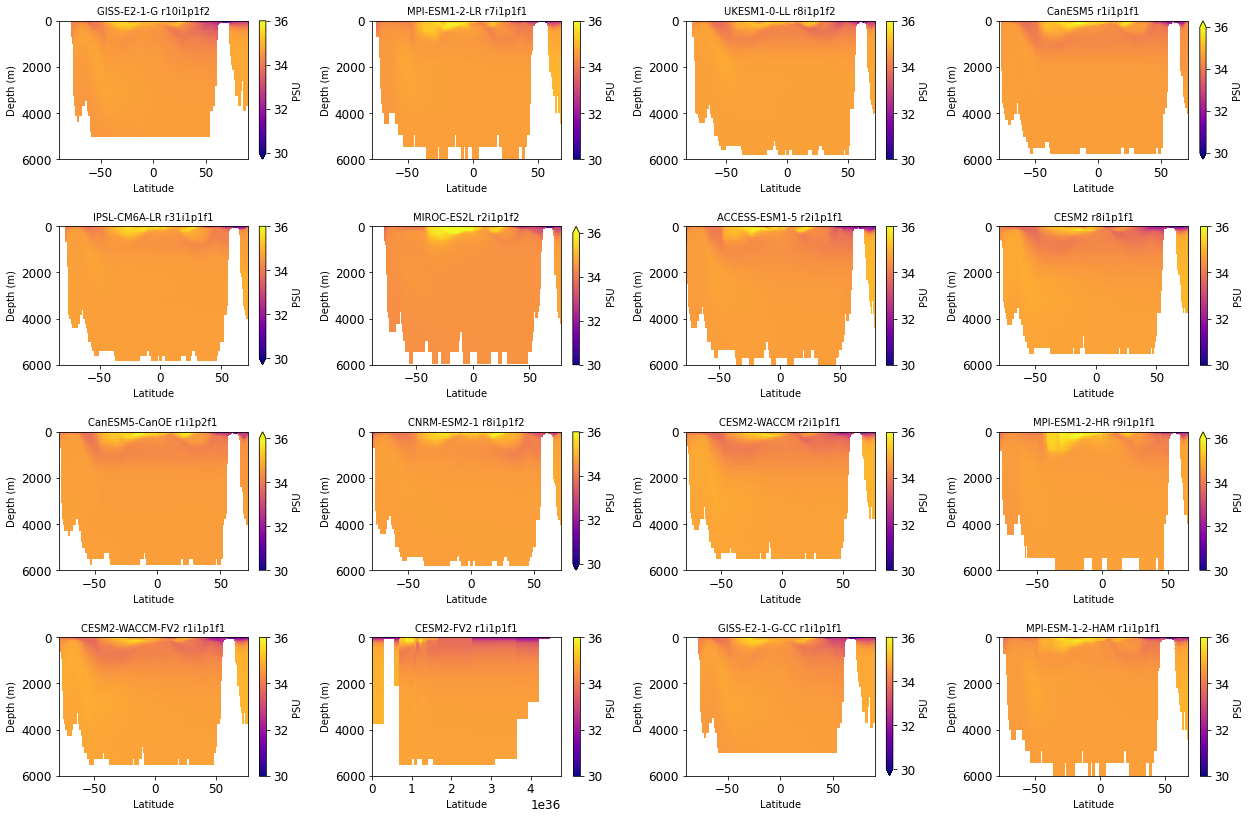

In [29]:
#You dont have to spell out all the axes, you can just keep them in an array
fig_so, axarr_so = plt.subplots(nrows = 4, ncols = 4, figsize=[18,12])
fig_so.tight_layout(pad = 3.5)
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 10)    
plt.rc('axes', labelsize= 10)
plt.rc('figure', titlesize=14)

#loop over each key, value pair of the dictionary
ax_idx = 0 # index for your axes array
for name, ds_so in dd_so_all.items():
    ax = axarr_so.flat[ax_idx]
    so_section = ds_so.so.where(np.logical_and(ds_so.lon<=200, ds_so.lon>=180), drop=True).isel(time = 0).mean('x', keep_attrs=True)
    im = so_section.plot(x='y', y='lev', yincrease=False, cmap = 'plasma', vmin=30, vmax=36, ax = ax, cbar_kwargs={'label':'PSU'})
    ax.set_title(ds_so.attrs['source_id']+ ' '+ds_so.attrs['variant_label'])
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Depth (m)')
    ax.set_ylim([6000, 0])
    ax_idx += 1 # this is a nifty python trick to increment a variable by one

### DIC

In [30]:
cat_DIC_all = col.search(source_id = ['IPSL-CM6A-LR', 'CNRM-ESM2-1', 'CESM2', 'CanESM5', 'CanESM5-CanOE', 
                             'MPI-ESM-1-2-HAM', 'UKESM1-0-LL', 'MPI-ESM1-2-LR', 'MPI-ESM1-2-HR', 
                             'CESM2-WACCM', 'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'MIROC-ES2L', 'ACCESS-ESM1-5',
                             'CESM2-WACCM-FV2', 'CESM2-FV2'], variable_id= 'dissic', experiment_id= 'historical', table_id = 'Omon', grid_label = 'gn')
dd_DIC_all_1 = cat_DIC_all.to_dataset_dict(
    zarr_kwargs={'consolidated': True, 'use_cftime':True},
    storage_options={'token': 'anon'},
    preprocess=combined_preprocessing,
    aggregate=False)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


CESM2-FV2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
MIROC-ES2L: No units found
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
CESM2-WACCM: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
CESM2-WACCM-FV2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
MIROC-ES2L: No units found
MIROC-ES2L: No units found
MIROC-ES2L: No units found
MIROC-ES2L: No units found
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
MIROC-ES2L: No units found
MIROC-ES2L: No units found
MIROC-ES2L: No units found
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
CESM2-FV2: Unexpected unit (centimeters) for coordinate `lev` detect

In [31]:
dd_DIC_all = combine_datasets(
    dd_DIC_all_1,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id'])

In [32]:
dd_DIC_all

{'UKESM1-0-LL.gn.historical.Omon': <xarray.Dataset>
 Dimensions:             (bnds: 2, lev: 75, time: 1980, vertices: 4, x: 360, y: 330)
 Coordinates:
   * x                   (x) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
   * y                   (y) float32 -83.45 -83.34 -83.23 ... 71.57 71.62 71.65
     lat                 (y, x) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
   * lev                 (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
     lev_bounds          (lev, bnds) float64 dask.array<chunksize=(75, 2), meta=np.ndarray>
     lon                 (y, x) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
   * time                (time) object 1850-01-16 00:00:00 ... 2014-12-16 00:0...
     time_bounds         (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
     vertices_latitude   (y, x, vertices) float32 dask.array<chunksize=(330, 360, 4), meta=np.ndarray>
     vertices_longitude  (y, x, vertices) float32 dask.

In [33]:
for name, dsa in dd_DIC_all.items():
    print(dsa.attrs['source_id']+' ' +dsa.attrs['variant_label']+' ' +dsa.attrs['table_id'])

UKESM1-0-LL r4i1p1f2 Omon
IPSL-CM6A-LR r10i1p1f1 Omon
CESM2-FV2 r2i1p1f1 Omon
CanESM5 r10i1p2f1 Omon
CNRM-ESM2-1 r8i1p1f2 Omon
ACCESS-ESM1-5 r6i1p1f1 Omon
CESM2 r7i1p1f1 Omon
MPI-ESM1-2-HR r2i1p1f1 Omon
MIROC-ES2L r1i1p1f2 Omon
MPI-ESM1-2-LR r8i1p1f1 Omon
CESM2-WACCM r1i1p1f1 Omon
CESM2-WACCM-FV2 r1i1p1f1 Omon
MPI-ESM-1-2-HAM r2i1p1f1 Omon
GISS-E2-1-G r101i1p1f1 Omon
CanESM5-CanOE r2i1p2f1 Omon
GISS-E2-1-G-CC r1i1p1f1 Omon


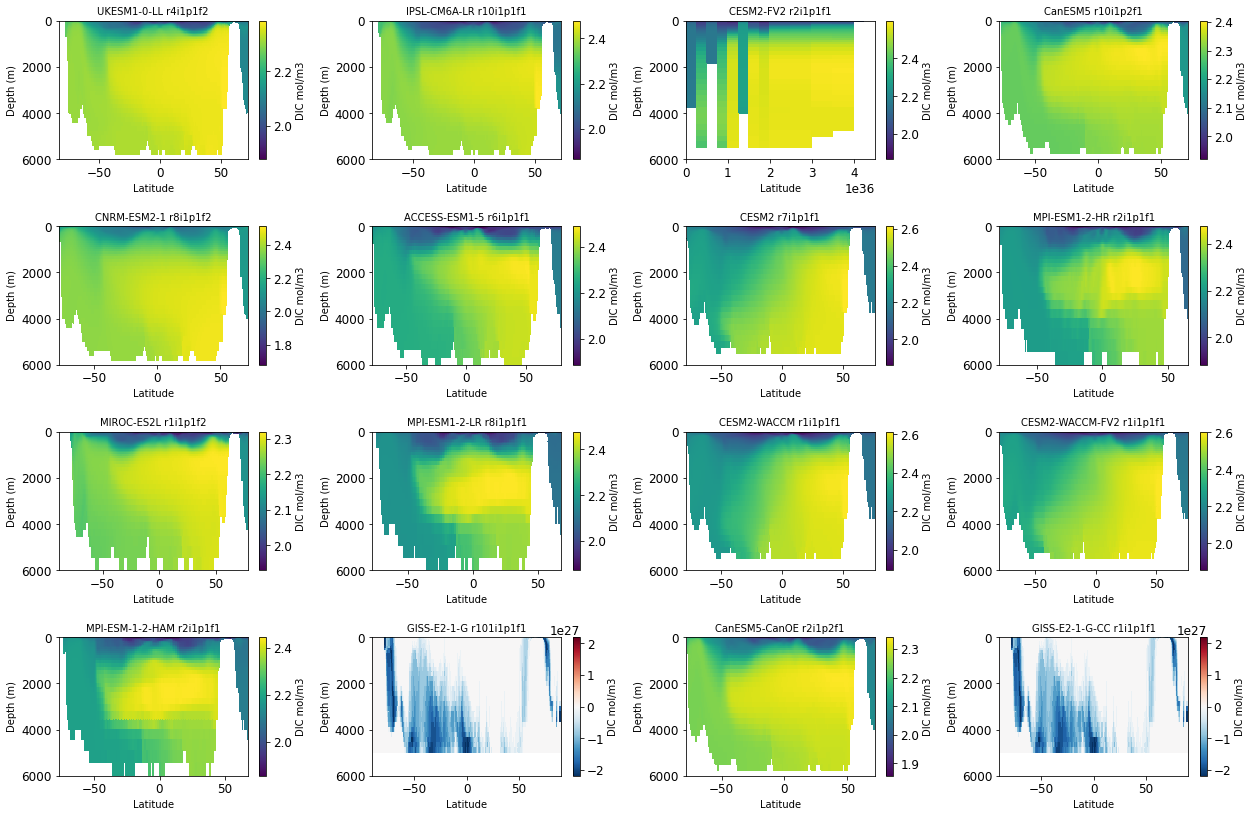

In [36]:
#You dont have to spell out all the axes, you can just keep them in an array
fig_DIC, axarr_DIC = plt.subplots(nrows = 4, ncols = 4, figsize=[18,12])
fig_DIC.tight_layout(pad = 3.5)
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 10)    
plt.rc('axes', labelsize= 10)
plt.rc('figure', titlesize=14)

#loop over each key, value pair of the dictionary
ax_idx = 0 # index for your axes array
for name, ds_DIC in dd_DIC_all.items():
    ax = axarr_DIC.flat[ax_idx]
    DIC_section = ds_DIC.dissic.where(np.logical_and(ds_DIC.lon<=200, ds_DIC.lon>=180), drop=True).isel(time = 0).mean('x', keep_attrs=True)
    im = DIC_section.plot(x='y', y='lev', yincrease=False, ax = ax, cbar_kwargs={'label':'DIC mol/m3'})
    ax.set_title(ds_DIC.attrs['source_id']+ ' '+ds_DIC.attrs['variant_label'])
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Depth (m)')
    ax.set_ylim([6000, 0])
    ax_idx += 1 # this is a nifty python trick to increment a variable by one

In [37]:
dd_DIC_all

{'UKESM1-0-LL.gn.historical.Omon': <xarray.Dataset>
 Dimensions:             (bnds: 2, lev: 75, time: 1980, vertices: 4, x: 360, y: 330)
 Coordinates:
   * x                   (x) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
   * y                   (y) float32 -83.45 -83.34 -83.23 ... 71.57 71.62 71.65
     lat                 (y, x) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
   * lev                 (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
     lev_bounds          (lev, bnds) float64 dask.array<chunksize=(75, 2), meta=np.ndarray>
     lon                 (y, x) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
   * time                (time) object 1850-01-16 00:00:00 ... 2014-12-16 00:0...
     time_bounds         (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
     vertices_latitude   (y, x, vertices) float32 dask.array<chunksize=(330, 360, 4), meta=np.ndarray>
     vertices_longitude  (y, x, vertices) float32 dask.

```
'CESM2-FV2.gn.historical.Omon': <xarray.Dataset>
 Dimensions:      (bnds: 2, lev: 60, time: 1980, vertex: 4, x: 320, y: 384)
 Coordinates:
     lat          (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
     lat_bounds   (y, x, vertex) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
   * lev          (lev) float64 5.0 15.0 25.0 ... 4.875e+03 5.125e+03 5.375e+03
     lev_bounds   (lev, bnds) float32 dask.array<chunksize=(60, 2), meta=np.ndarray>
     lon          (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
     lon_bounds   (y, x, vertex) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
   * y            (y) float64 -66.4 -65.87 -65.33 ... 4.486e+36 4.486e+36
   * x            (x) float64 1.063 2.188 3.313 4.438 ... 356.6 357.7 358.8 359.9
   * time         (time) object 1850-01-15 13:00:00 ... 2014-12-15 12:00:00
     time_bounds  (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
   * bnds         (bnds) int64 0 1
   * vertex       (vertex) int64 0 1 2 3
 Data variables:
     dissic       (time, lev, y, x) float32 dask.array<chunksize=(4, 60, 384, 320), meta=np.ndarray>
 Attributes:
     Conventions:             CF-1.7 CMIP-6.2
     activity_id:             CMIP
     branch_method:           standard
     branch_time_in_child:    674885.0
     branch_time_in_parent:   10950.0
     case_id:                 1560
     cesm_casename:           b.e21.BHIST.f19_g17.CMIP6-historical-2deg.002
     contact:                 cesm_cmip6@ucar.edu
     creation_date:           2019-11-05T01:11:50Z
     data_specs_version:      01.00.31
     experiment:              Simulation of recent past (1850 to 2014). Impose...
     experiment_id:           historical
     external_variables:      areacello volcello
     forcing_index:           1
     frequency:               mon
     further_info_url:        https://furtherinfo.es-doc.org/CMIP6.NCAR.CESM2-...
     grid:                    native gx1v7 displaced pole grid (384x320 latxlon)
     grid_label:              gn
     initialization_index:    1
     institution:             National Center for Atmospheric Research, Climat...
     institution_id:          NCAR
     license:                 CMIP6 model data produced by <The National Cente...
     mip_era:                 CMIP6
     model_doi_url:           https://doi.org/10.5065/D67H1H0V
     nominal_resolution:      250 km
     parent_activity_id:      CMIP
     parent_experiment_id:    piControl
     parent_mip_era:          CMIP6
     parent_source_id:        CESM2-FV2
     parent_time_units:       days since 0001-01-01 00:00:00
     parent_variant_label:    r1i1p1f1
     physics_index:           1
     product:                 model-output
     realization_index:       2
     realm:                   ocnBgchem
     source:                  CESM2 (2017): atmosphere: CAM6 (1.9x2.5 finite v...
     source_id:               CESM2-FV2
     source_type:             AOGCM BGC AER
     status:                  2020-04-11;created; by gcs.cmip6.ldeo@gmail.com
     sub_experiment:          none
     sub_experiment_id:       none
     table_id:                Omon
     tracking_id:             hdl:21.14100/ea304d92-62c6-4319-b883-6b098b42ef7...
     variable_id:             dissic
     variant_info:            CMIP6 CESM2-FV2 historical experiment (1850-2014...
     variant_label:           r2i1p1f1
     netcdf_tracking_ids:     hdl:21.14100/ea304d92-62c6-4319-b883-6b098b42ef7...
     version_id:              v20200226
     intake_esm_varname:      None
     intake_esm_dataset_key:  CMIP.NCAR.CESM2-FV2.historical.r2i1p1f1.Omon.dis...,
     

In [38]:
dd_DIC_all['GISS-E2-1-G-CC.gn.historical.Omon']

<xarray.Dataset>
Dimensions:      (bnds: 2, lev: 40, time: 1980, x: 288, y: 180)
Coordinates:
  * y            (y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bounds   (y, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
  * lev          (lev) float64 5.0 16.0 29.0 ... 4.453e+03 4.675e+03 4.897e+03
    lev_bounds   (lev, bnds) float64 dask.array<chunksize=(40, 2), meta=np.ndarray>
  * x            (x) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
    lon_bounds   (x, bnds) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time         (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bounds  (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * bnds         (bnds) int64 0 1
    lon          (x, y) float64 0.625 0.625 0.625 0.625 ... 359.4 359.4 359.4
    lat          (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Data variables:
    dissic       (time, lev, y, x) float32 dask.array<chunksize=(12, 40, 180, 288), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    0.0
    branch_time_in_parent:   0.0
    cmor_version:            3.3.2
    contact:                 Kenneth Lo (cdkkl@giss.nasa.gov)
    creation_date:           2019-08-30T00:14:44Z
    data_specs_version:      01.00.23
    experiment:              all-forcing simulation of the recent past
    experiment_id:           historical
    external_variables:      areacello
    forcing_index:           1
    frequency:               mon
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.NASA-GISS.G...
    grid:                    atmospheric grid: 144x90, ocean grid: 288x180
    grid_label:              gn
    history:                 2019-08-30T00:14:44Z ; CMOR rewrote data to be c...
    initialization_index:    1
    institution:             Goddard Institute for Space Studies, New York, N...
    institution_id:          NASA-GISS
    license:                 CMIP6 model data produced by NASA Goddard Instit...
    mip_era:                 CMIP6
    model_id:                Egigcc_exp30
    nominal_resolution:      250 km
    parent_activity_id:      CMIP
    parent_experiment_id:    piControl
    parent_experiment_rip:   r1i1p1
    parent_mip_era:          CMIP6
    parent_source_id:        GISS-E2-1-G-CC
    parent_time_units:       days since 1850-1-1
    parent_variant_label:    r1i1p1f1
    physics_index:           1
    product:                 model-output
    realization_index:       1
    realm:                   ocnBgChem
    references:              https://data.giss.nasa.gov/modelE/cmip6
    source:                  GISS-E2.1G-CC (2016): \naerosol: Varies with phy...
    source_id:               GISS-E2-1-G-CC
    source_type:             AOGCM
    sub_experiment:          none
    sub_experiment_id:       none
    table_id:                Omon
    table_info:              Creation Date:(21 March 2018) MD5:f396f2dd5f6f49...
    title:                   GISS-E2-1-G-CC output prepared for CMIP6
    tracking_id:             hdl:21.14100/46afa8d8-b63e-402c-aa01-1aeae32cac4...
    variable_id:             dissic
    variant_label:           r1i1p1f1
    status:                  2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:     hdl:21.14100/46afa8d8-b63e-402c-aa01-1aeae32cac4...
    version_id:              v20190815
    intake_esm_varname:      None
    intake_esm_dataset_key:  CMIP.NASA-GISS.GISS-E2-1-G-CC.historical.r1i1p1f...

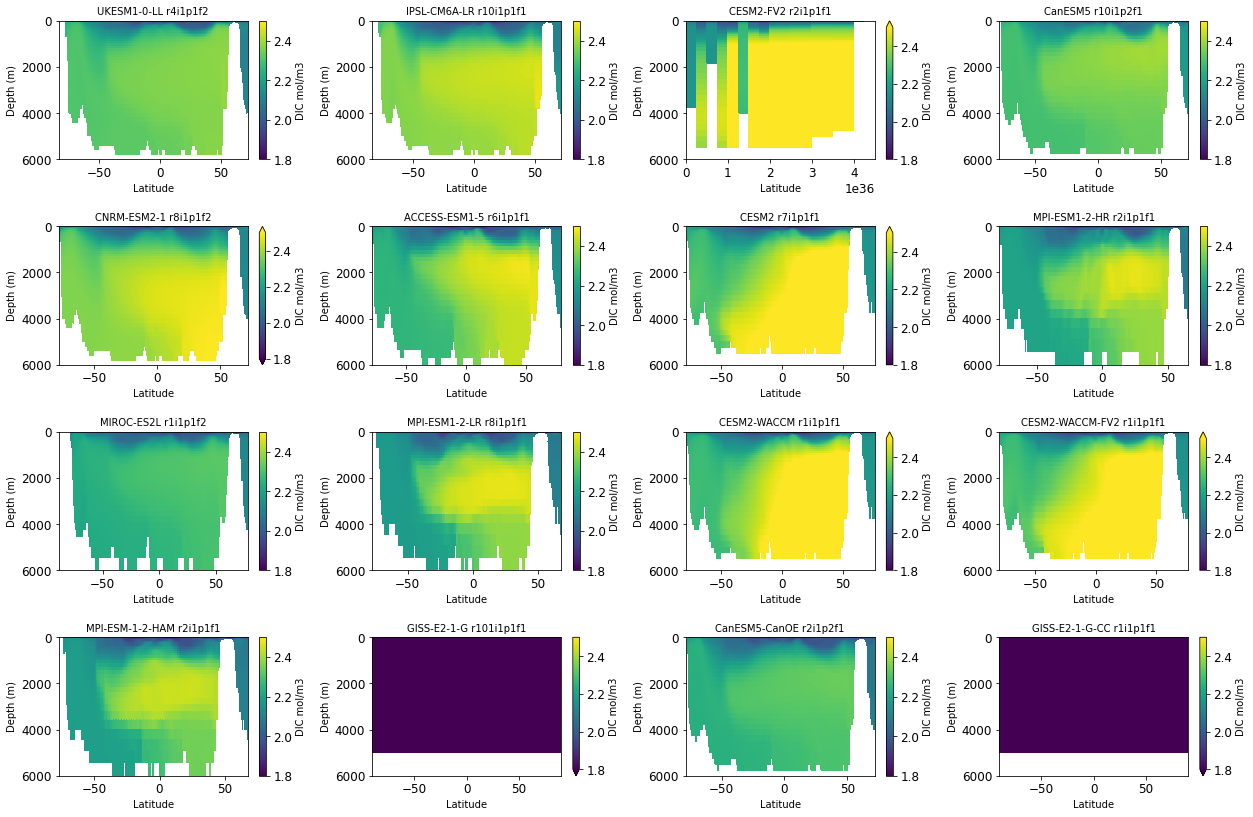

In [40]:
#You dont have to spell out all the axes, you can just keep them in an array
fig_DIC_2, axarr_DIC_2 = plt.subplots(nrows = 4, ncols = 4, figsize=[18,12])
fig_DIC_2.tight_layout(pad = 3.5)
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 10)    
plt.rc('axes', labelsize= 10)
plt.rc('figure', titlesize=14)

#loop over each key, value pair of the dictionary
ax_idx = 0 # index for your axes array
for name, ds_DIC_2 in dd_DIC_all.items():
    ax = axarr_DIC_2.flat[ax_idx]
    DIC_section_2 = ds_DIC_2.dissic.where(np.logical_and(ds_DIC_2.lon<=200, ds_DIC_2.lon>=180), drop=True).isel(time = 0).mean('x', keep_attrs=True)
    im = DIC_section_2.plot(x='y', y='lev', yincrease=False, ax = ax, vmin = 1.8, vmax = 2.5, cbar_kwargs={'label':'DIC mol/m3'})
    ax.set_title(ds_DIC_2.attrs['source_id']+ ' '+ds_DIC_2.attrs['variant_label'])
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Depth (m)')
    ax.set_ylim([6000, 0])
    #ax.set_xlim([-90, 90])
    ax_idx += 1 # this is a nifty python trick to increment a variable by one

### Thetao

In [41]:
cat_thetao_all = col.search(source_id = ['IPSL-CM6A-LR', 'CNRM-ESM2-1', 'CESM2', 'CanESM5', 'CanESM5-CanOE', 
                             'MPI-ESM-1-2-HAM', 'UKESM1-0-LL', 'MPI-ESM1-2-LR', 'MPI-ESM1-2-HR', 
                             'CESM2-WACCM', 'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'MIROC-ES2L', 'ACCESS-ESM1-5',
                             'CESM2-WACCM-FV2', 'CESM2-FV2'], variable_id= 'thetao', experiment_id= 'historical', table_id = 'Omon', grid_label = 'gn')
dd_thetao_all_1 = cat_thetao_all.to_dataset_dict(
    zarr_kwargs={'consolidated': True, 'use_cftime':True},
    storage_options={'token': 'anon'},
    preprocess=combined_preprocessing,
    aggregate=False)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


MIROC-ES2L: No units found
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
MIROC-ES2L: No units found
CESM2-WACCM: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
CESM2-FV2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
MIROC-ES2L: No units found
MIROC-ES2L: No units found
CESM2-WACCM: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
MIROC-ES2L: No units found
MIROC-ES2L: No units found
MIROC-ES2L: No units found
MIROC-ES2L: No units found
MIROC-ES2L: No units found
MIROC-ES2L: No units found
MIROC-ES2L: No units found
CESM2-FV2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Conv

In [44]:
dd_thetao_all = combine_datasets(
    dd_thetao_all_1,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id'])

In [45]:
dd_thetao_all

{'GISS-E2-1-G.gn.historical.Omon': <xarray.Dataset>
 Dimensions:      (bnds: 2, lev: 40, time: 1980, x: 288, y: 180)
 Coordinates:
   * y            (y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
     lat_bounds   (y, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
   * lev          (lev) float64 5.0 16.0 29.0 ... 4.453e+03 4.675e+03 4.897e+03
     lev_bounds   (lev, bnds) float64 dask.array<chunksize=(40, 2), meta=np.ndarray>
   * x            (x) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
     lon_bounds   (x, bnds) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
   * time         (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
     time_bounds  (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
   * bnds         (bnds) int64 0 1
     lon          (x, y) float64 0.625 0.625 0.625 0.625 ... 359.4 359.4 359.4
     lat          (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
 Data variables:
 

In [46]:
for name, dsb in dd_thetao_all.items():
    print(dsb.attrs['source_id']+' ' +dsb.attrs['variant_label']+' ' +dsb.attrs['table_id'])

GISS-E2-1-G r9i1p1f1 Omon
MIROC-ES2L r1i1000p1f2 Omon
IPSL-CM6A-LR r3i1p1f1 Omon
CanESM5 r23i1p1f1 Omon
CanESM5-CanOE r1i1p2f1 Omon
UKESM1-0-LL r13i1p1f2 Omon
MPI-ESM1-2-HR r3i1p1f1 Omon
ACCESS-ESM1-5 r13i1p1f1 Omon
MPI-ESM1-2-LR r4i1p1f1 Omon
CNRM-ESM2-1 r5i1p1f2 Omon
CESM2 r8i1p1f1 Omon
CESM2-WACCM r2i1p1f1 Omon
CESM2-FV2 r3i1p1f1 Omon
MPI-ESM-1-2-HAM r2i1p1f1 Omon
CESM2-WACCM-FV2 r3i1p1f1 Omon
GISS-E2-1-G-CC r1i1p1f1 Omon


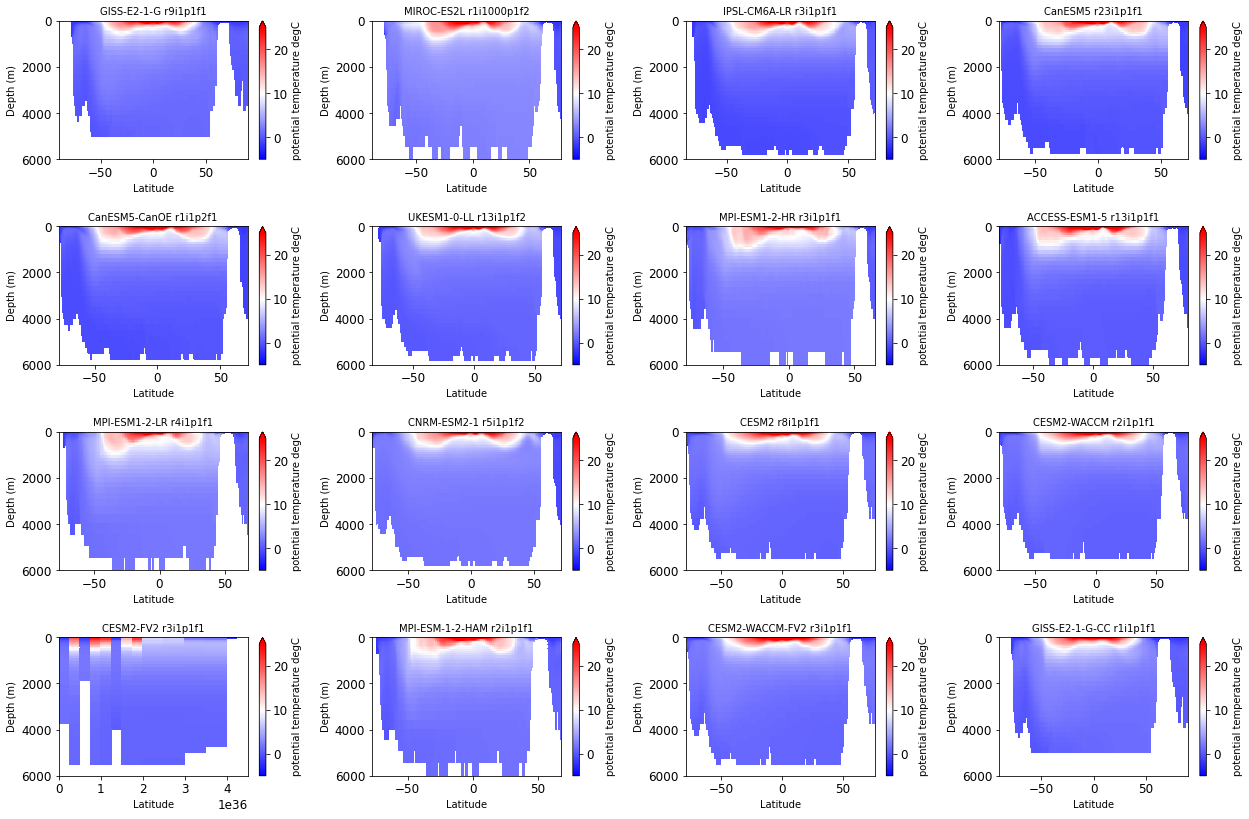

In [47]:
#You dont have to spell out all the axes, you can just keep them in an array
fig_thetao, axarr_thetao = plt.subplots(nrows = 4, ncols = 4, figsize=[18,12])
fig_thetao.tight_layout(pad = 3.5)
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 10)    
plt.rc('axes', labelsize= 10)
plt.rc('figure', titlesize=14)

#loop over each key, value pair of the dictionary
ax_idx = 0 # index for your axes array
for name, ds_thetao in dd_thetao_all.items():
    ax = axarr_thetao.flat[ax_idx]
    thetao_section = ds_thetao.thetao.where(np.logical_and(ds_thetao.lon<=200, ds_thetao.lon>=180), drop=True).isel(time = 0).mean('x', keep_attrs=True)
    im = thetao_section.plot(x='y', y='lev', yincrease=False, cmap = 'bwr', vmin = -5, vmax = 25, ax = ax, cbar_kwargs={'label':'potential temperature degC'})
    ax.set_title(ds_thetao.attrs['source_id']+ ' '+ds_thetao.attrs['variant_label'])
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Depth (m)')
    ax.set_ylim([6000, 0])
    ax_idx += 1 # this is a nifty python trick to increment a variable by one

### Alkalinity

In [48]:
cat_talk_all = col.search(source_id = ['IPSL-CM6A-LR', 'CNRM-ESM2-1', 'CESM2', 'CanESM5', 'CanESM5-CanOE', 
                             'MPI-ESM-1-2-HAM', 'UKESM1-0-LL', 'MPI-ESM1-2-LR', 'MPI-ESM1-2-HR', 
                             'CESM2-WACCM', 'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'MIROC-ES2L', 'ACCESS-ESM1-5',
                             'CESM2-WACCM-FV2', 'CESM2-FV2'], variable_id= 'talk', experiment_id= 'historical', table_id = 'Omon', grid_label = 'gn')
dd_talk_all_1 = cat_talk_all.to_dataset_dict(
    zarr_kwargs={'consolidated': True, 'use_cftime':True},
    storage_options={'token': 'anon'},
    preprocess=combined_preprocessing,
    aggregate=False)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'
CESM2-WACCM-FV2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`


CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
MIROC-ES2L: No units found
CESM2-FV2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
MIROC-ES2L: No units found
MIROC-ES2L: No units found
MIROC-ES2L: No units found
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
MIROC-ES2L: No units found
CESM2-FV2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
MIROC-ES2L: No units found
MIROC-ES2L: No units found
CESM2-WACCM: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
MIROC-ES2L: No units found
MIROC-ES2L: No units found
MIROC-ES2L: No units found
CESM2: Unexpected un

In [49]:
dd_talk_all = combine_datasets(
    dd_talk_all_1,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id'])

In [50]:
dd_talk_all

{'CESM2-WACCM-FV2.gn.historical.Omon': <xarray.Dataset>
 Dimensions:      (bnds: 2, lev: 60, time: 1980, vertex: 4, x: 320, y: 384)
 Coordinates:
     lat          (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
     lat_bounds   (y, x, vertex) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
   * lev          (lev) float64 5.0 15.0 25.0 ... 4.875e+03 5.125e+03 5.375e+03
     lev_bounds   (lev, bnds) float32 dask.array<chunksize=(60, 2), meta=np.ndarray>
     lon          (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
     lon_bounds   (y, x, vertex) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
   * y            (y) float64 -79.22 -78.69 -78.15 -77.62 ... 77.21 77.21 77.22
   * x            (x) float64 1.063 2.188 3.313 4.438 ... 356.6 357.7 358.8 359.9
   * time         (time) object 1850-01-15 13:00:00.000007 ... 2014-12-15 12:0...
     time_bounds  (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
   *

In [51]:
for name, dsc in dd_talk_all.items():
    print(dsc.attrs['source_id']+' ' +dsc.attrs['variant_label']+' ' +dsc.attrs['table_id'])

CESM2-WACCM-FV2 r3i1p1f1 Omon
CanESM5 r9i1p2f1 Omon
UKESM1-0-LL r11i1p1f2 Omon
CESM2 r2i1p1f1 Omon
MPI-ESM1-2-LR r7i1p1f1 Omon
CNRM-ESM2-1 r6i1p1f2 Omon
ACCESS-ESM1-5 r19i1p1f1 Omon
IPSL-CM6A-LR r28i1p1f1 Omon
MIROC-ES2L r20i1p1f2 Omon
GISS-E2-1-G r101i1p1f1 Omon
CanESM5-CanOE r2i1p2f1 Omon
CESM2-FV2 r1i1p1f1 Omon
MPI-ESM-1-2-HAM r2i1p1f1 Omon
MPI-ESM1-2-HR r1i1p1f1 Omon
CESM2-WACCM r1i1p1f1 Omon
GISS-E2-1-G-CC r1i1p1f1 Omon


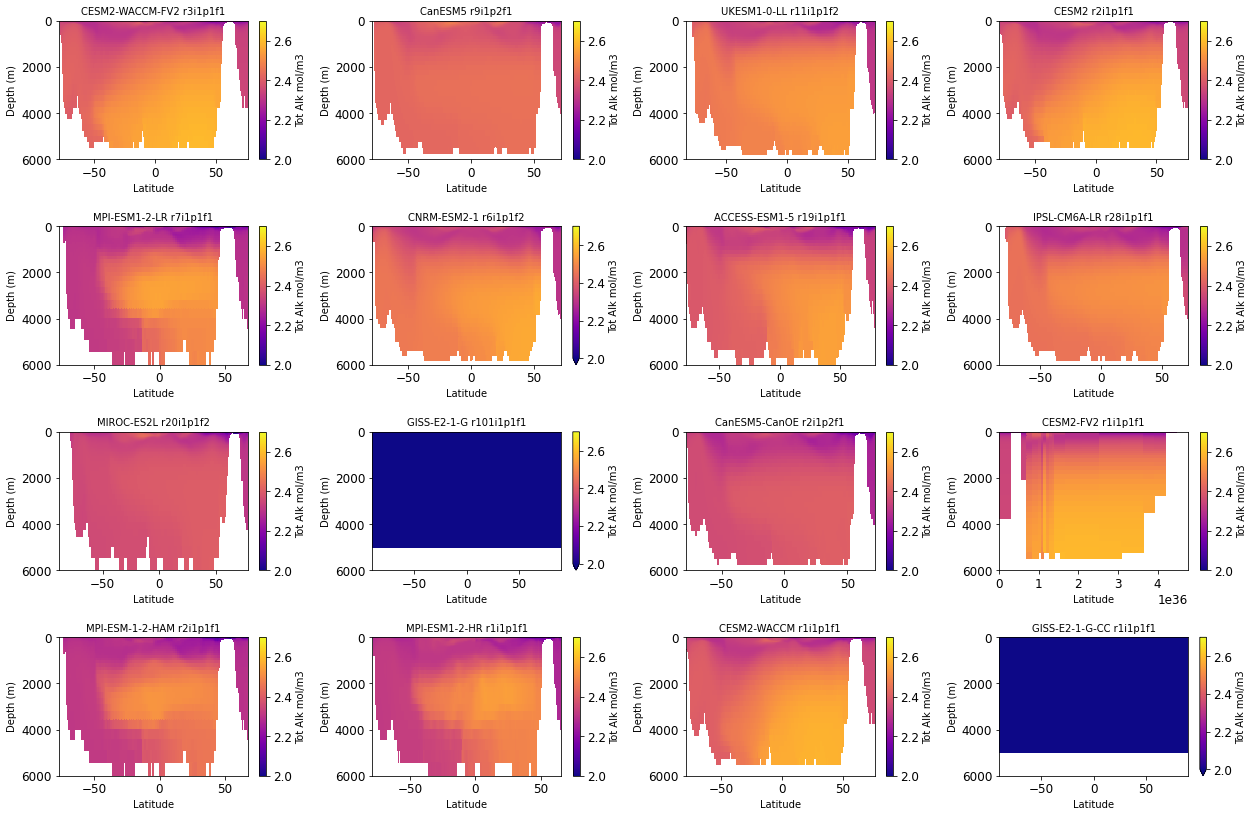

In [53]:
#You dont have to spell out all the axes, you can just keep them in an array
fig_talk, axarr_talk = plt.subplots(nrows = 4, ncols = 4, figsize=[18,12])
fig_talk.tight_layout(pad = 3.5)
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 10)    
plt.rc('axes', labelsize= 10)
plt.rc('figure', titlesize=14)

#loop over each key, value pair of the dictionary
ax_idx = 0 # index for your axes array
for name, ds_talk in dd_talk_all.items():
    ax = axarr_talk.flat[ax_idx]
    talk_section = ds_talk.talk.where(np.logical_and(ds_talk.lon<=200, ds_talk.lon>=180), drop=True).isel(time = 0).mean('x', keep_attrs=True)
    im = talk_section.plot(x='y', y='lev', yincrease=False, vmin = 2, vmax = 2.7, cmap = 'plasma', ax = ax, cbar_kwargs={'label':'Tot Alk mol/m3'})
    ax.set_title(ds_talk.attrs['source_id']+ ' '+ds_talk.attrs['variant_label'])
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Depth (m)')
    ax.set_ylim([6000, 0])
    ax_idx += 1 # this is a nifty python trick to increment a variable by one